# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.preprocessing import OneHotEncoder

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data  Exploration

In [3]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [5]:
profile['id'].nunique()

17000

Text(0,0.5,'count')

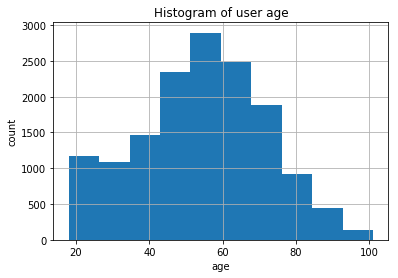

In [9]:

profile[profile['age']!= 118]['age'].hist()
plt.title('Histogram of user age')
plt.xlabel('age')
plt.ylabel('count')

In [7]:
profile['age'].sort_values().unique()

array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 118])

Text(0,0.5,'count')

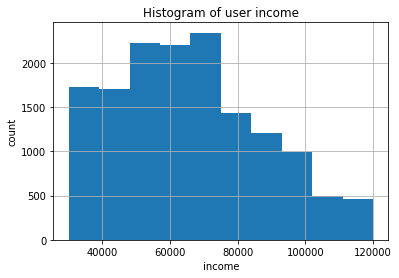

In [8]:
profile['income'].hist()
plt.title('Histogram of user income')
plt.xlabel('income')
plt.ylabel('count')

In [9]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [10]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [11]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Text(0.5,1,'bar chart of events')

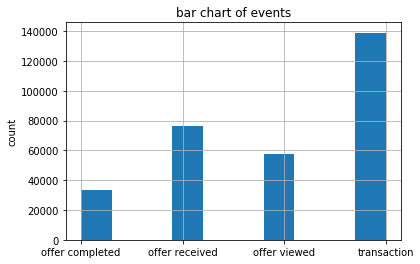

In [12]:
transcript['event'].hist()
plt.ylabel('count')
plt.title('bar chart of events')

In [13]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [14]:
transcript[transcript['event'] == 'offer viewed']['value'].head()

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [15]:
transcript[transcript['event'] == 'offer completed']['value'][12658]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [16]:
transcript[transcript['event'] == 'transaction']['value'].head()

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
Name: value, dtype: object

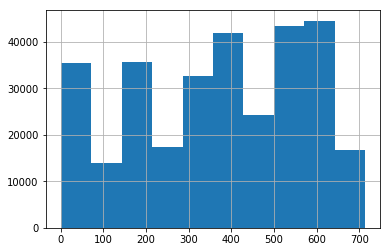

In [17]:
transcript['time'].hist()

# Data preparation

## clean portfolio Dataset

To Do

1) rename id with offer_id
2) replace offer type with dummy columns
3) replace channel with dummy columns

In [18]:
portfolio_cleaned = portfolio.copy() 

portfolio_cleaned.rename(columns={'id':'offer_id'},inplace=True)

offer_type_dummies = pd.get_dummies(portfolio_cleaned['offer_type'])

portfolio_cleaned = pd.concat([portfolio_cleaned.drop(columns='offer_type'),offer_type_dummies], axis=1)

portfolio_cleaned.head()

,channels,difficulty,duration,offer_id,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0


In [19]:
channel_dummies = pd.DataFrame(index=portfolio_cleaned.index)

for i in portfolio_cleaned.index: 
    
    for channel in portfolio_cleaned['channels'][i]: 
        
        if (channel in channel_dummies)== False:
            
            channel_dummies[channel] = 0
        
        channel_dummies[channel][i] = 1
            
portfolio_cleaned = pd.concat([portfolio_cleaned.drop(columns='channels'),channel_dummies], axis=1)

portfolio_cleaned.head()

,difficulty,duration,offer_id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


## clean profile DataFrame

To Do

1) rename id with user_id to distinguish from offer id 
2) clean age column by replacing age 118 with Nan
3) replacing Gender entry None with Nan
4) droping all rows where gender, age and income are NaN
5) add a column with member duration in years
6) convert gender to dummy columns

In [20]:
profile_cleaned = profile.copy()

profile_cleaned.rename(columns={'id':'user_id'},inplace=True)

profile_cleaned = profile_cleaned.replace({'age': 118,'gender': None},np.nan)

profile_cleaned.dropna(subset=['age','gender','income'], how='all', inplace = True)

In [21]:
profile_cleaned.head()

,age,became_member_on,gender,user_id,income
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [22]:
profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'],format='%Y%m%d')

profile_cleaned['member_duration'] = (datetime.today() - pd.to_datetime(profile_cleaned['became_member_on'])).astype('timedelta64[Y]').astype('int')
#https://stackoverflow.com/questions/30950198/attributeerror-timedeltaproperties-object-has-no-attribute-years-in-pandas

profile_cleaned.drop(columns='became_member_on', inplace=True)

In [23]:
profile_cleaned.head()

,age,gender,user_id,income,member_duration
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,5
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,5
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,4
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,4
12,58.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,5


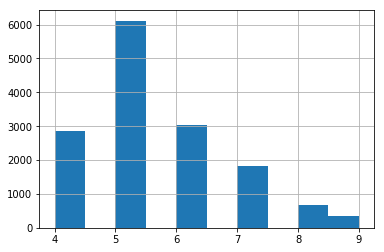

In [24]:
profile_cleaned['member_duration'].hist()

In [25]:
gender_dummies = pd.get_dummies(profile_cleaned['gender']).drop(columns='O')

profile_cleaned = pd.concat([profile_cleaned.drop(columns='gender'), gender_dummies], axis=1)

profile_cleaned.head()

,age,user_id,income,member_duration,F,M
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,5,1,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,5,1,0
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,4,0,1
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,4,0,1
12,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,5,0,1


## Clean transcript

To Do

1) rename person in use_id
2) extract offer_id form value ( is NaN if it was not from an offer) 


In [26]:
transcript_cleaned = transcript.copy()

transcript_cleaned.rename(columns={'person':'user_id'},inplace=True)

In [27]:
# extract offer_id from value

value_df = pd.DataFrame.from_records(list(transcript_cleaned['value']), index=transcript_cleaned.index)

value_df['offer_id'].fillna(value_df['offer id'], inplace=True)

value_df.drop(columns='offer id', inplace=True)

value_df.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [28]:
transcript_cleaned = pd.concat([transcript_cleaned.drop(columns='value'), value_df],sort=False,axis=1)

transcript_cleaned.head()

,event,user_id,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [29]:
transcript_cleaned[transcript_cleaned['user_id'] == '78afa995795e4d85b5d9ceeca43f5fef']

,event,user_id,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,NaN,NaN
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,29.72,NaN,NaN
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,23.93,NaN,NaN


convert transcript DataFrame to a dataframe, that shows each interaction of a user with an offer with the following columns: 

user_id
offer_id
viewed
completed
transact_amount

In [30]:
interactions = pd.DataFrame(columns=['user_id','offer_id','viewed','completed','transact_amount'])

for user_id in transcript_cleaned['user_id'].unique(): 
    
    #print(user_id)
    
    user_interactions = transcript_cleaned[transcript_cleaned['user_id'] == user_id].sort_values(by='time')
    
    #print(user_interactions.head())
    
    for i in user_interactions.index: 
        
        if user_interactions['event'][i] == 'offer received':
        
            offer_id = user_interactions['offer_id'][i]
        
            # initialize a row in interactions
            interaction_i = pd.Series(index=interactions.columns)
            
            interaction_i['user_id'] = user_id
            
            interaction_i['offer_id'] = offer_id
            
            # get next events for this offer id
            
            next_interactions = user_interactions[user_interactions['offer_id'] == offer_id].reset_index()
            
            #check if the offer was viewed
            
            if (len(next_interactions) >=2):
                    
                if (next_interactions['event'][1] == 'offer viewed'):
                
                    interaction_i['viewed'] = 1

                    # check if the offer was completed

                    if (len(next_interactions) >=3):
                        
                        if (next_interactions['event'][2] == 'offer completed'): 

                            interaction_i['completed'] = 1

                            completion_time = next_interactions['time'][2]

                            #find the transaction that correspond sto this offer

                            corresponding_transaction = user_interactions[(user_interactions['time'] == completion_time) 
                                                                         & (user_interactions['event'] == 'transaction')]

                            if len(corresponding_transaction) == 1: 

                                interaction_i['transact_amount'] = corresponding_transaction['amount'].values[0]

                            elif len(corresponding_transaction) > 1:

                                print(corresponding_transaction)

                                break

            
            #append to the interactions df
            
            interaction_i = interaction_i.to_frame().T
            
            #print(interaction_i)
                
            interactions = pd.concat([interactions,interaction_i],axis=0)
                
                
                
            #break # breaks after one interaction 
                
    #print(interactions)
            
    #break #breaks after one user
        
        
#else: 
#    continue
        
#break
                

In [31]:
interactions.head()

,user_id,offer_id,viewed,completed,transact_amount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,19.89
0,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,NaN,NaN
0,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,21.72
0,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,NaN,NaN


In [32]:
# save dataframes after cleaning
interactions.to_pickle('interactions.pickle')
portfolio_cleaned.to_pickle('portfolio_cleaned.pickle')
profile_cleaned.to_pickle('profile_cleaned.pickle')

# Model Data

We want to predict if a user turns an offer into a transaction. We are using the dataset to predict the 'offer_completed' column.

I want to test different models and lokk at ho well they perform on a test set

In [16]:
#load dataframes
interactions = pd.read_pickle('interactions.pickle')
portfolio_cleaned = pd.read_pickle('portfolio_cleaned.pickle')
profile_cleaned = pd.read_pickle('profile_cleaned.pickle')

In [17]:
interactions.shape

(76277, 5)

In [18]:
interactions.head()

,user_id,offer_id,viewed,completed,transact_amount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,19.89
0,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,NaN,NaN
0,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,21.72
0,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,NaN,NaN


In [19]:
interactions.fillna(value=0, inplace=True)
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 0
Data columns (total 5 columns):
user_id            76277 non-null object
offer_id           76277 non-null object
viewed             76277 non-null int64
completed          76277 non-null int64
transact_amount    76277 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.5+ MB


In [20]:
# unite all data to one DF
df_all = interactions.merge(portfolio_cleaned, how='left', on='offer_id')
df_all.shape

(76277, 15)

In [21]:
df_all = df_all.merge(profile_cleaned, how='left', on='user_id')
df_all.shape

(76277, 20)

In [22]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 76276
Data columns (total 20 columns):
user_id            76277 non-null object
offer_id           76277 non-null object
viewed             76277 non-null int64
completed          76277 non-null int64
transact_amount    76277 non-null float64
difficulty         76277 non-null int64
duration           76277 non-null int64
reward             76277 non-null int64
bogo               76277 non-null uint8
discount           76277 non-null uint8
informational      76277 non-null uint8
email              76277 non-null int64
mobile             76277 non-null int64
social             76277 non-null int64
web                76277 non-null int64
age                66496 non-null float64
income             66496 non-null float64
member_duration    66496 non-null float64
F                  66496 non-null float64
M                  66496 non-null float64
dtypes: float64(6), int64(9), object(2), uint8(3)
memory usage: 10.7+ MB


In [23]:
df_all['viewed'].mean()

0.69444262359557929

In [24]:
# clean df_all to get rid of NaN values and of interactions where the user did not viewed the offer
df_all.dropna(inplace=True)
df_all = df_all[df_all['viewed'] == 1]
df_all.drop(columns='viewed', inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45219 entries, 0 to 76276
Data columns (total 19 columns):
user_id            45219 non-null object
offer_id           45219 non-null object
completed          45219 non-null int64
transact_amount    45219 non-null float64
difficulty         45219 non-null int64
duration           45219 non-null int64
reward             45219 non-null int64
bogo               45219 non-null uint8
discount           45219 non-null uint8
informational      45219 non-null uint8
email              45219 non-null int64
mobile             45219 non-null int64
social             45219 non-null int64
web                45219 non-null int64
age                45219 non-null float64
income             45219 non-null float64
member_duration    45219 non-null float64
F                  45219 non-null float64
M                  45219 non-null float64
dtypes: float64(6), int64(8), object(2), uint8(3)
memory usage: 6.0+ MB


# Modeling of the Data

I want to try to predict if a user completes an offer and I  want to test different approaches to do this: 

1) logistic regression
2) Random Forest classifier

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Logistic regression

In [26]:
# devide data in training and test set

X = df_all.drop(columns=['completed','user_id','offer_id'])

y = df_all['completed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
Res_df = pd.DataFrame(index=['train_score','test_score'], columns=['logistic regression','random forest classifier'])

In [28]:
# model the data

#fit the model on the training data
reg = LogisticRegression(random_state=0).fit(X_train, y_train)

#score the model
Res_df['logistic regression']['train_score'] = reg.score(X_train, y_train)
Res_df['logistic regression']['test_score'] = reg.score(X_test, y_test)

In [29]:
# view parameters
reg_coeffs = pd.Series(data=reg.coef_[0],index=X_train.columns)
reg_coeffs

transact_amount    2.348425
difficulty         0.110806
duration           0.013839
reward            -0.308168
bogo              -0.146790
discount           0.326913
informational     -0.370498
email             -0.190375
mobile            -0.109886
social             0.043672
web                0.097244
age               -0.026054
income            -0.000059
member_duration    0.047314
F                 -0.109089
M                 -0.077023
dtype: float64

## Random Forest Classifier

In [30]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

#score the model
Res_df['random forest classifier']['train_score'] = clf.score(X_train, y_train)
Res_df['random forest classifier']['test_score'] = clf.score(X_test, y_test)

In [31]:
Res_df

,logistic regression,random forest classifier
train_score,0.996897,0.999967
test_score,0.995845,1


In [35]:
#hyperparameter tuning
params = {'max_depth':[2,4,6]}
clf_tuned = GridSearchCV(clf, params)
clf_tuned.fit(X_train, y_train)

clf_tuned.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator__bootstrap': True,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': 2,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 10,
 'estimator__n_jobs': 1,
 'estimator__oob_score': False,
 'estimator__random_state': 0,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_sta

## Model improvement

The model performace is pretty good. So there is no need to improve the model here. But lets see if we can built a model  that does not need any information about the user. This could be helpful to reccomend offers for new users or users who do not enter the information. 

To check this, I will drop all columns with user information and train the models again

In [64]:
user_info_cols = ['age','income','member_duration','F','M']

X_train_2 = X_train.drop(columns=user_info_cols)

X_test_2 = X_test.drop(columns=user_info_cols)

Res_df['logistic regression wo user info'] = np.nan

Res_df['random forest classifier wo user info'] = np.nan

In [67]:
#fit the model on the training data
reg_2 = LogisticRegression(random_state=0).fit(X_train_2, y_train)

#score the model
Res_df['logistic regression wo user info']['train_score'] = reg.score(X_train_2, y_train)
Res_df['logistic regression wo user info']['test_score'] = reg.score(X_test_2, y_test)

print(reg.score(X_test_2, y_test))

0.999664946727


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_2, y_train)

#score the model
Res_df['random forest classifier wo user info']['train_score'] = clf.score(X_train_2, y_train)
Res_df['random forest classifier wo user info']['test_score'] = clf.score(X_test_2, y_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
Res_df

,logistic regression,random forest classifier,logistic regression wo user info,random forest classifier wo user info
train_score,0.996897,0.999967,0.999637,1.0
test_score,0.995845,1,0.999665,1.0
